In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [2]:

# Load and preprocess the dataset
def load_dataset(data_folders):
    X, y = [], []
    for label, data_folder in enumerate(data_folders):
        for filename in os.listdir(data_folder):
            img_path = os.path.join(data_folder, filename)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            X.append(img_array)
            y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

# Paths to augmented folders
augmented_class_0_path = r"E:\dataset_temp\class_0a"
augmented_class_1_path = r"E:\dataset_temp\augmented_class_1"

# Load the dataset
X, y = load_dataset([augmented_class_0_path, augmented_class_1_path])


In [3]:
# Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [4]:
# Print counts
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 2495
Validation set size: 312
Test set size: 312


In [5]:
#Create ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for train, validation, and test sets
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = train_datagen.flow(X_val, y_val, batch_size=32)
test_generator = train_datagen.flow(X_test, y_test, batch_size=32)


In [6]:
# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

In [7]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


In [8]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)


Epoch 1/10
77/77 [==============================] - 65s 664ms/step - loss: 0.6732 - accuracy: 0.5737 - val_loss: 0.6525 - val_accuracy: 0.7917
Epoch 2/10
77/77 [==============================] - 53s 687ms/step - loss: 0.6340 - accuracy: 0.6667 - val_loss: 0.6282 - val_accuracy: 0.7743
Epoch 3/10
77/77 [==============================] - 62s 801ms/step - loss: 0.6072 - accuracy: 0.7174 - val_loss: 0.5900 - val_accuracy: 0.7569
Epoch 4/10
77/77 [==============================] - 77s 1s/step - loss: 0.5839 - accuracy: 0.7515 - val_loss: 0.5630 - val_accuracy: 0.7604
Epoch 5/10
77/77 [==============================] - 91s 1s/step - loss: 0.5699 - accuracy: 0.7548 - val_loss: 0.5510 - val_accuracy: 0.7535
Epoch 6/10
77/77 [==============================] - 152s 2s/step - loss: 0.5570 - accuracy: 0.7649 - val_loss: 0.5562 - val_accuracy: 0.7708
Epoch 7/10
77/77 [==============================] - 260s 3s/step - loss: 0.5437 - accuracy: 0.7787 - val_loss: 0.5501 - val_accuracy: 0.7951
Epoch 8/1

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 19s 2s/step - loss: 0.5221 - accuracy: 0.8077
Test Loss: 0.5220602750778198
Test Accuracy: 0.807692289352417


In [11]:
# Save the model
model_save_path = "resnet50_binary_classification_model.h5"
model.save(model_save_path)
print("Model saved successfully at:", model_save_path)

Model saved successfully at: resnet50_binary_classification_model.h5


1/1 [==============================] - 1s 994ms/step


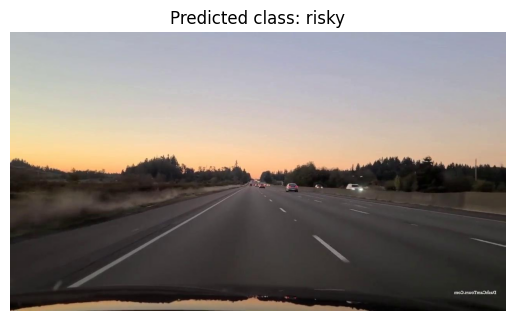

1/1 [==============================] - 0s 24ms/step


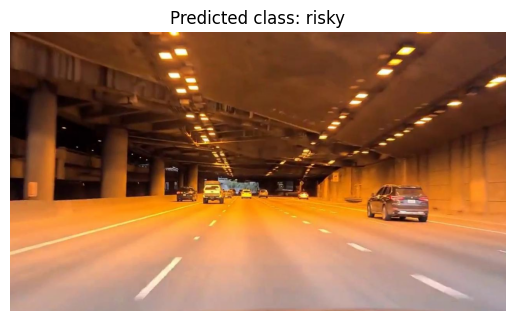

1/1 [==============================] - 0s 25ms/step


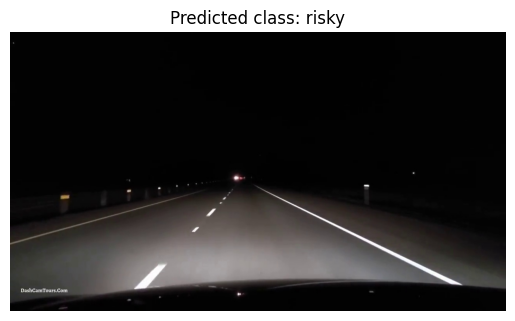

1/1 [==============================] - 0s 34ms/step


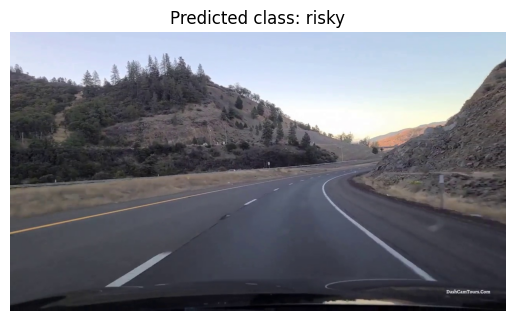

1/1 [==============================] - 0s 32ms/step


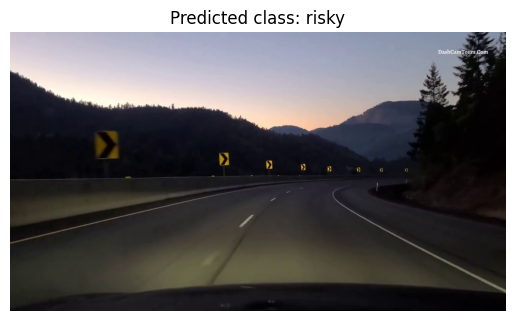

1/1 [==============================] - 0s 24ms/step


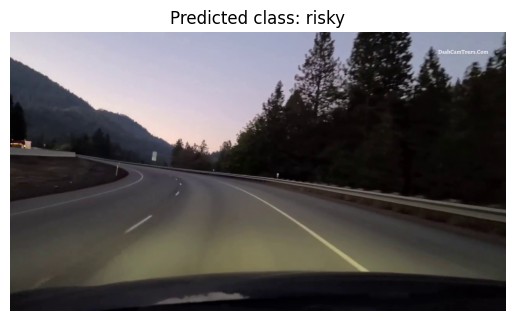

1/1 [==============================] - 0s 31ms/step


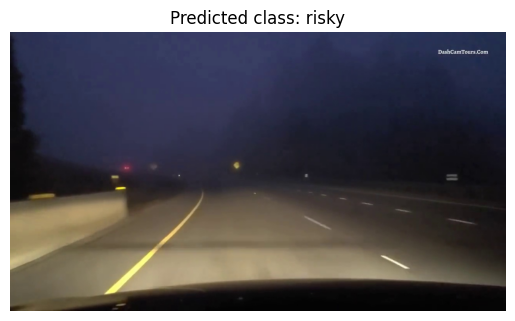

1/1 [==============================] - 0s 27ms/step


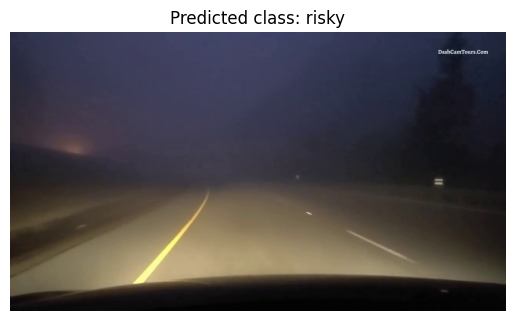

1/1 [==============================] - 0s 33ms/step


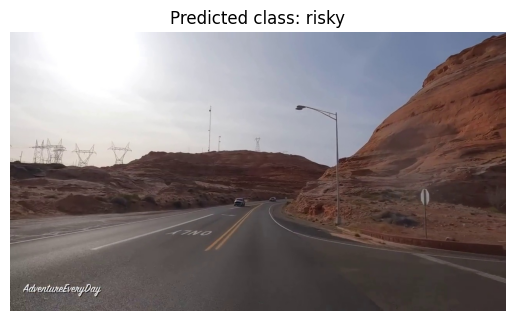

1/1 [==============================] - 0s 50ms/step


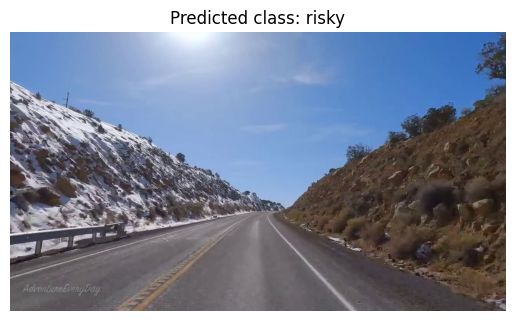

1/1 [==============================] - 0s 21ms/step


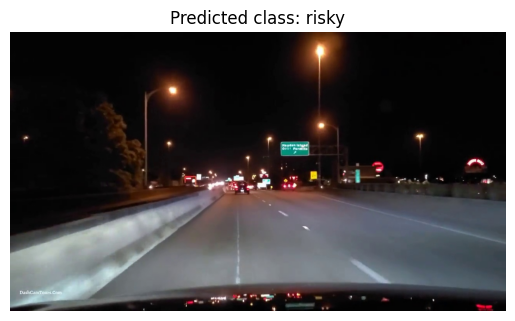

1/1 [==============================] - 0s 31ms/step


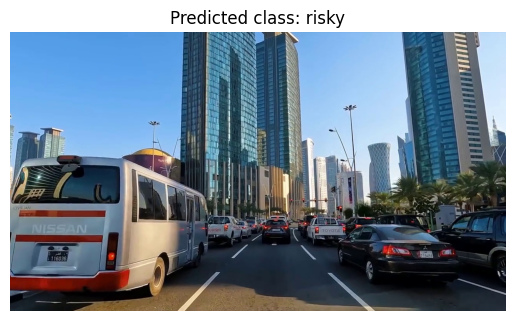

1/1 [==============================] - 0s 35ms/step


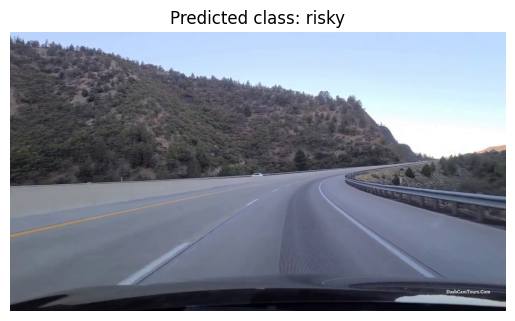

[('2 (185)_flipped.jpg', 1), ('2 (24)_zoomed.jpg', 1), ('test (1).jpg', 1), ('test (10).jpg', 1), ('test (11).jpg', 1), ('test (12).jpg', 1), ('test (13).jpg', 1), ('test (14).jpg', 1), ('test (2).jpg', 1), ('test (3).jpg', 1), ('test (4).jpg', 1), ('test (8).jpg', 1), ('test (9).jpg', 1)]


In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_on_images(model, image_folder):
    predictions = []
    class_labels = ['not risky', 'risky']
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize images to the same size as the training images
            img = np.expand_dims(img, axis=0)  # Add batch dimension
            pred = model.predict(img)
            predicted_class = np.round(pred).astype(int)[0][0]  # Round the prediction to 0 or 1
            predictions.append((filename, predicted_class))
            # Display the image with its predicted class
            plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
            plt.title(f"Predicted class: {class_labels[predicted_class]}")
            plt.axis('off')
            plt.show()
    return predictions

# Call the function with your loaded model and test image folder
model_load_path = "resnet50_binary_classification_model.h5"
model = tf.keras.models.load_model(model_load_path)
image_folder = r"E:\dataset_temp\test"
predictions = predict_on_images(model, image_folder)
print(predictions)
